# Customer Churn Analysis

## Aim is to build a model to predict the Customer accounts that are at the Risk of Churning.

#### The below code shows the libraries imported.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

## FEATURE ENGINEERING

#### The below dataframe (DF1) exhibit the attributes pertaining to an account user at an outlet (E-commerce/Factory Retail).
#### Every outlet comprises of attributes of Account_ID, Date and the Number of Transactions or Count.
#### Every account ID, relate to a number of transactions on a particular date, all of which are placed in synchronous to the transaction counts respectively.
#### The logs in the data can consist of transactions repeated on a different date.
#### The dates are DISTINCT for each account ID. Note that there can be redundant logs with same data in account ID and Date.

In [2]:
df1 = pd.read_csv('./counts.csv')
df1.head()

,account,date,count
0,5e0a5eb5575517efdddb2799c90e2e9b,2017-08-16,56
1,a04e063493c55bc6cecd9056712e9e47,2017-08-16,180
2,ff6cc8cadcb7457f9ddb2dd238a13733,2017-08-16,432
3,324a05f1f917b8a0af83a54e55a1ef63,2017-08-16,50
4,b9abff45dc08172b556cb10b7c3c2252,2017-08-16,135


#### The below dataframe (DF2) exhibit the attributes pertaining to an account user at an outlet (E-commerce/Factory Retail).
#### Every outlet comprises of attributes of Account_ID, Date, and Amount Spend for the respective date.
#### Every sum amount of transactions is synchronous to an account ID that is DISTINCT on a particular date.
#### The Date format is in UNIX Timestamp format.
#### The logs in the data can consist of Total Sum Amount repeated on a different date.
#### The dates are DISTINCT for each account ID. Note that there can be redundant logs with same data in account ID and Date.

In [3]:
df2 = pd.read_csv('./spend.csv')
df2.head()

,account,date,amount
0,5e0a5eb5575517efdddb2799c90e2e9b,1502841600,15.144020
1,a04e063493c55bc6cecd9056712e9e47,102841600,730.070453
2,ff6cc8cadcb7457f9ddb2dd238a13733,1502841600,3651.412248
3,324a05f1f917b8a0af83a54e55a1ef63,1502841600,113.219243
4,b9abff45dc08172b556cb10b7c3c2252,1502841600,697.224210


#### The below dataframe shows the consolidation of data by abstracting the date field in DF1.
#### The dataframe comprises of columns with Account ID, date, and Count (Number of Transactions per User).
#### Abstracting the date field involves removal of specification of day(dd) from format yyyy-mm-dd resulting yyyy-mm.
#### Thus, results demonstrate a table with account details, along with redundant dates, and count.
#### General Observation: The data analysis made over the month is conducive than that of the analysis made with a duration of a day.
#### 1. Greater Coverage
#### 2. Data availability over a duration, rather than a particular date only.

In [4]:
df1["date"] = pd.to_datetime(df1['date']).dt.to_period('M') 
df1.head()

,account,date,count
0,5e0a5eb5575517efdddb2799c90e2e9b,2017-08,56
1,a04e063493c55bc6cecd9056712e9e47,2017-08,180
2,ff6cc8cadcb7457f9ddb2dd238a13733,2017-08,432
3,324a05f1f917b8a0af83a54e55a1ef63,2017-08,50
4,b9abff45dc08172b556cb10b7c3c2252,2017-08,135


#### The below dataframe shows the consolidation of data by abstracting the date field in DF2.
#### The dataframe comprises of columns with Account ID, date, and Amount Spend for the date in specific.
#### The date field is converted to yyyy-mm-dd format from traditional UNIX timestamp as above in DF2.
#### Abstracting the date field involves removal of specification of day(dd) from format yyyy-mm-dd to yyyy-mm.
#### Thus, results demonstrate a table with account details, along redundant dates (yyyy-mm), and Amount of Spend of each user.
#### General Observation: The data analysis made over the month is conducive than that of the analysis made with a duration of a day because of
#### 1. Greater Coverage
#### 2. Data availability over a duration, rather than a particular date only.

In [5]:
df2["date"] = pd.to_datetime(df2['date'], unit='s').dt.to_period('M') 
df2.head()

,account,date,amount
0,5e0a5eb5575517efdddb2799c90e2e9b,2017-08,15.144020
1,a04e063493c55bc6cecd9056712e9e47,1973-04,730.070453
2,ff6cc8cadcb7457f9ddb2dd238a13733,2017-08,3651.412248
3,324a05f1f917b8a0af83a54e55a1ef63,2017-08,113.219243
4,b9abff45dc08172b556cb10b7c3c2252,2017-08,697.224210


#### The below dataframes df1_count and df2_spend illustrate the determined summation of Count and Amount of Spend respectively.

#### The below DataFrame DF1 will perform the following:
#### 1. The logs in DF1 are grouped by the account ID and date.
#### 2. The logs comprising of same date values, will be total/sum of Count altogether.
#### 3. The shape functions realizes the number of account ID and number of Columns.

#### The below DataFrame DF2 will perform the following:
#### 1. The logs in DF2 are grouped by the account ID and date.
#### 2. The logs comprising of same date values, will be total/sum of Amount of Spend altogether.
#### 3. The shape functions realizes the number of account ID and number of Columns.

#### General Observation: We observe from the below code output that Transaction Amount have been Spent, without the existance of ID of Transaction for respective Amount Spend i.e 9.

In [6]:
df1_count = df1.groupby(['account', 'date'])['count'].sum().rename_axis(['account','date']).reset_index()
df2_spend = df2.groupby(['account','date'])['amount'].sum().rename_axis(['account','date']).reset_index()
df2_spend.shape, df1_count.shape

((128525, 3), (128516, 3))

#### The below dataframe df shows the LEFT MERGE of all instances in df1_count with respective instances in df2_spend.
#### This is done to achieve a target dataframe that will comprise of Account ID, Date, Count, and Amount of Spend.
#### Purpose of LEFT MERGE: To elimate the presence of Amount of Spend log without a Count in the resultant dataframe.

In [7]:
df = pd.merge(df1_count, df2_spend, on=['account','date'], how='left')
df.shape

(128516, 4)

#### To obtain the analysis of the resultant dataframe df, the start/end dates are considered.
#### Minimum date or the start date for the data present is obtained with a function min().
#### Purpose of Timestamps: The customer behaviour, predictive analysis can be scrutinized in a particular duration of events.

In [8]:
df['date'].min()

Period('2017-08', 'M')

#### To obtain the analysis of the resultant dataframe df, the start/end dates are considered.
#### Maximum date or the end date for the data present is obtained with a function max().
#### Purpose of Timestamps: The customer behaviour, predictive analysis can be scrutinized in a particular duration of events.
#### Observation: The difference between date-max() and date-min() comprise a term of 20 months as a result.

In [9]:
df['date'].max()

Period('2019-03', 'M')

#### The operations below are applied on dataframe df, to obtain a final result of date in an ascending order.
#### To obtain the dates in Ascending order, we have applied the following steps:
#### 1. Applied lambda function to convert the date format of df.date from yyyy-mm to string 'yyyy-mm'
#### 2. Using replace functions, we are detecting the characters in a string df.date that are not digits and replace with empty character.
#### 3. Using astype() function, we convert the data in df.date field to an integer of having internal format as yyyymm.
#### 4. We proceed to sort the date by value in an Ascending order.

In [10]:
df['date'] = df['date'].apply(lambda x: x.strftime('%Y-%m')) 
df['date'] = df['date'].str.replace('\D', '').astype(int)
df.sort_values("date", inplace=True, ascending=True)
df.head(10)

,account,date,count,amount
64457,81b70e12a890fb18fe927879ee08d328,201708,288,7043.474362
33208,419ec41453ee4354a77c6d5685128b80,201708,208,668.842302
54131,6c0e204e5d4e98325e795d60af4e6263,201708,228,1107.023920
74793,972dd137f176bfa617c58c70fef07031,201708,78,79.477892
118742,ed3ae91fa8f36e712afef05f82caeb45,201708,380,462.747402
33228,41a2d33c9aeede2ac178c02d8082f09f,201708,120,82.435397
33281,41aa29c9913a7f634ec3c29e4d63d1f9,201708,264,1380.409385
125389,fa6265b3298c31a27e44cf31e0a27320,201708,570,4132.298185
33308,41c8ba45131af87aac524091f6a3112f,201708,15,610.860563
74829,97412930bf054adc540c7798f79b54b9,201708,90,2632.069262


#### The below code shows an addition of column to dataframe df by name Average Amount('avg_amount').
#### The Average Amount of each transaction is the total money held by the Account holder by the total number of transactions.

In [11]:
df['avg_amount'] = df['amount'] / df['count']
df.head()

,account,date,count,amount,avg_amount
64457,81b70e12a890fb18fe927879ee08d328,201708,288,7043.474362,24.456508
33208,419ec41453ee4354a77c6d5685128b80,201708,208,668.842302,3.215588
54131,6c0e204e5d4e98325e795d60af4e6263,201708,228,1107.023920,4.855368
74793,972dd137f176bfa617c58c70fef07031,201708,78,79.477892,1.018947
118742,ed3ae91fa8f36e712afef05f82caeb45,201708,380,462.747402,1.217756


#### In the below dataframe, we have a resultant pivot table(final_pivot_count) to unveil the relation between the Account and date field employing the transaction count at regular intervals, as per data during the duration 20 months.
#### Base condition: If no transaction count is available for any account user at a particular month(timestamp), the value populated for that field is a zero(0).

In [12]:
final_pivot_count = df.pivot_table(index='account', columns='date', values='count', fill_value=0)
final_pivot_avgamt = df.pivot_table(index='account', columns='date', values='avg_amount', fill_value=0)
final_pivot_count.head()

date,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808,201809,201810,201811,201812,201901,201902,201903
account,,,,,,,,,,,,,,,,,,,,
00023fda963eb48839a670cbdf74cd21,0,0,0,14,70,28,56,56,0,28,0,14,56,56,84,112,168,210,196,112
000458145e8ff76fb2907417d806d098,0,0,0,0,0,0,51,102,238,170,187,289,153,119,340,306,391,459,357,238
000b2159adf33dcb44291291e0575122,3504,6132,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
000cff3bf5b20e8bb5734eb0aeef6673,400,656,912,1616,2176,1616,1536,2000,2000,2720,2000,1536,1680,1776,3104,2880,2928,80,0,0
000f6054933c882efb96bc34b91c8924,0,0,0,56,28,42,0,84,182,490,308,308,350,294,560,266,210,420,490,336


#### In the below dataframe, we have a resultant pivot table(final_pivot_avgamt) to unveil the relation between the Account and date field employing the average amount(double float) at regular intervals, as per data during the duration 20 months.
#### Base condition: If no average amount is available for any account user at a particular month(timestamp), the value populated for that field is a zero(0.000000).

In [13]:
final_pivot_avgamt.head()

date,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808,201809,201810,201811,201812,201901,201902,201903
account,,,,,,,,,,,,,,,,,,,,
00023fda963eb48839a670cbdf74cd21,0.000000,0.000000,0.000000,59.939290,10.094643,3.973378,15.95421,16.390149,0.000000,4.347366,0.000000,2.823124,9.935434,89.426312,4.822293,22.420560,8.851833,12.915232,9.547750,17.713072
000458145e8ff76fb2907417d806d098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.13103,11.692936,7.139763,6.182491,6.803157,8.574156,3.878286,4.182635,4.044704,6.598601,6.482846,10.176290,3.575653,3.777975
000b2159adf33dcb44291291e0575122,2.998179,3.153910,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
000cff3bf5b20e8bb5734eb0aeef6673,6.683284,3.216557,4.955353,4.663603,4.027564,8.924607,6.10824,8.514516,8.399626,5.429320,5.236970,5.666654,5.979246,6.323429,4.897767,3.239734,3.908577,4.737631,0.000000,0.000000
000f6054933c882efb96bc34b91c8924,0.000000,0.000000,0.000000,4.216378,0.947114,1.657758,0.00000,7.133818,2.259741,2.719146,2.665213,2.548640,2.243896,3.683083,2.639037,2.691810,1.636886,5.755314,4.527622,6.343015


#### The below code will render an estimate/calculation to the number of average customers at each month, during the analysis period of over 20 months.
#### The percentage of Active Customers a month can be determined by the number of active customers being made available by the total number of account holder (Sum of Active and Passive Customers).
#### Post-creating an empty list, we further proceed to append the values of these percentages calculated to yield a consistent data to number of Active Customers a month.

In [14]:
activeCustomer_rate = []
for i in final_pivot_count.columns:
    val = 0
    for j in final_pivot_count[i]:
        if j > 0:
            val +=1
    activeCustomer_rate.append(val / 9999)

#### The below list activeCustomer_rate displays the values of percentage of active customers for each month over the duration of 20 months i.e. list containing 20 values/length.

In [15]:
activeCustomer_rate

[0.31683168316831684,
 0.39893989398939894,
 0.45144514451445145,
 0.5014501450145015,
 0.5404540454045405,
 0.5424542454245425,
 0.5866586658665867,
 0.6134613461346134,
 0.6469646964696469,
 0.6943694369436944,
 0.7365736573657365,
 0.8342834283428343,
 0.8105810581058106,
 0.8111811181118112,
 0.8031803180318032,
 0.7778777877787779,
 0.7527752775277528,
 0.7096709670967096,
 0.6874687468746875,
 0.6362636263626362]

#### The below graph represents the curve along the axes that represent date and active customer percentage(as calculated above -> activeCustomer_rate) along the lines of X-axis and Y-axis respectively.
#### Observations: 
#### 1. We notice start date of the duration of analysis i.e. df.min() is 201708. We also notice that the number of Active Customers involved with organization are the least in number.
#### 2. We take into observation that the Active Customers for the organization grew/increase over the period of 201708 to 201807 linearly. 
#### 3. The peak value of Number of Active Customers for the organization observed is in 201807.
#### 4. We take into observation that the Active Customers for the organization diminished/decreased over the period of 201807 to 201903 linearly. 
#### 5. The Observed Last Month during the duration of Analysis is 201903 for the organization.

#### Self Forethought: As per my observation from the graph, the enterprise was exposed to gradual decrease in Customer post 201807. The Organization should make efforts to predict the accounts at Risk or Churning and realize the reasons to decline in Active Customers. Thus, I believe the last 8 months of the data should be under critical consideration to avoid any further casualty.

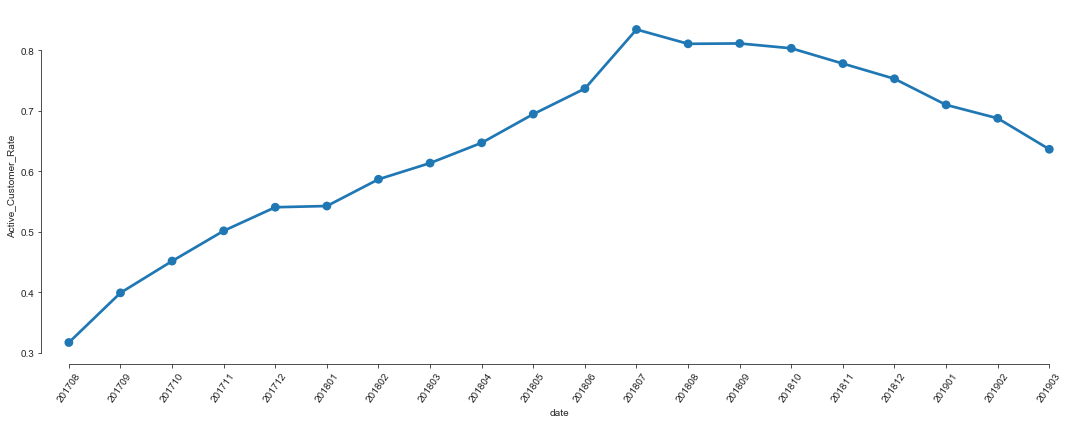

In [16]:
plt.figure(figsize=(15, 6))
sns.set_style("ticks")
g = sns.pointplot(final_pivot_count.columns, activeCustomer_rate)
sns.despine(trim=True, offset=2)
g.set_xticklabels(final_pivot_count.columns, rotation=55, ha="center")
plt.tight_layout()
plt.ylabel('Active_Customer_Rate')
plt.show()

#### The code below will eliminate the multiple indexes issue pertaining to the pivot tables above.

In [17]:
final_pivot_count.rename_axis(['date']).reset_index(inplace=True)
final_pivot_avgamt.rename_axis(['date']).reset_index(inplace=True)
del final_pivot_count.columns.name
del final_pivot_avgamt.columns.name

#### Considering the dataframe for the last 8 months (in the total duration of 20 months), reason being the decline in Active Customers to the Organization, we further proceed to pick a pivot value as the mid value of the total tenure in consideration.
#### By means, mid value of total duration in consideration will be 4 months.
#### We further proceed to segment the data in fragments for each month, playing along the dates 201808-201903
#### Notice that we have two segments here, for the first half segment(s1) bearing the duration 201808-201811, and then the second half segment(s2) would bear the duration 201812-201903
#### The average of the count for each segment, named by 'before_count' and 'after_count' for first half of segment(s1) and second half of segment(s2) is calculated respectively.
#### These columns 'before_count' and 'after_count' are appended to the final_pivot_count dataframe along with populating their values upon calculations.

In [18]:
#Using Count

# 4 months
final_pivot_count['before_count'] = final_pivot_count.iloc[:, -8:-4].sum(axis=1) /4
final_pivot_count['after_count'] = final_pivot_count.iloc[:, -5:-1].sum(axis=1) / 4

#### The average of Transaction Amount for each segment, named by 'before_avgamt' and 'after_avgamt' for first half of segment(s1) and second half of segment(s2) is calculated respectively.
#### These columns 'before_avgamt' and 'after_avgamt' are appended to the final_pivot_avgamt dataframe along with populating their values upon calculations.

In [19]:
#Using avg_amount

# 4 months
final_pivot_avgamt['before_avgamt'] = final_pivot_avgamt.iloc[:, -8:-4].sum(axis=1) /4
final_pivot_avgamt['after_avgamt'] = final_pivot_avgamt.iloc[:, -5:-1].sum(axis=1) / 4

#### The code below, shows the percentage increase/decrease in discrete segments s1 and s2.
#### The increase/decrease in percentage of average count is calculated by the difference between the after_count values and before_count values upon the before_count values. 
#### The increase/decrease in percentage of average amount is calculated by the difference between the after_avgamt values and before_avgamt values upon the before_avgamt values. 

In [20]:
final_pivot_count['percentage_count'] = (final_pivot_count['after_count'] - final_pivot_count['before_count']) / final_pivot_count['before_count'] * 100
final_pivot_avgamt['percentage_avgamt'] = (final_pivot_avgamt['after_avgamt'] - final_pivot_avgamt['before_avgamt']) / final_pivot_avgamt['before_avgamt'] * 100

#### In previous code, we calculate the percentage of the increase/decrease in count values. 
#### Going through which, we apply a lambda function, which is a single line statement to check a condition is satisfied.
#### The condition that the lamda will check are:
#### 1. If there is a increase in percentage count, then the target value is set to 1.
#### 2. If there is a decrease in percentage count greater than 75%, then the target value is set to 0, else the target is set to 1.
#### 3. If a customer does not show up for the past 8 months i.e. the duration in consideration, then the count percentage is NaN meaning the Customer has already Churned.

#### Detect Percentage Increase/Decrese: The detection in increase or decrease is done through the difference between the count values in before_count and after_count upon count values in before_count say from segment s1 and segment s2.
#### 1. If the percentage returned is positive, then it is a increase in customer loyalty.
#### 2. If the percentage returned is negative, then it is a decrease in customer loyalty.

#### Reason for 75% Boundary: The reason for considering a 75% boundary on a change in count percentage is because of as follows:
#### 1. The organization needs to be alarmed, provided there is a drastic decrease in customer loyalty.
#### 2. The organization should be notified of irregualrity in transaction, for a customer's approach. The customer transacting a fair amount at a particular instance, and then call a no-show is of critical concerns to organization's fortune.

#### Reason for NaN: NaN means that the customer has a no-show for the whole duration under consideration. The percentage of increase/decrease shows no Transaction count, having to put through NaN in the change in percentage of count/amount column as a specifics for No-Show.

In [21]:
final_pivot_count['target_count'] = final_pivot_count['percentage_count'].apply(lambda x : 1 if (x >= -75) else 0)
final_pivot_count.head(20)

,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,...,201810,201811,201812,201901,201902,201903,before_count,after_count,percentage_count,target_count
account,,,,,,,,,,,,,,,,,,,,,
00023fda963eb48839a670cbdf74cd21,0,0,0,14,70,28,56,56,0,28,...,84,112,168,210,196,112,77.00,171.50,122.727273,1
000458145e8ff76fb2907417d806d098,0,0,0,0,0,0,51,102,238,170,...,340,306,391,459,357,238,229.50,361.25,57.407407,1
000b2159adf33dcb44291291e0575122,3504,6132,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.00,0.00,NaN,0
000cff3bf5b20e8bb5734eb0aeef6673,400,656,912,1616,2176,1616,1536,2000,2000,2720,...,3104,2880,2928,80,0,0,2360.00,752.00,-68.135593,1
000f6054933c882efb96bc34b91c8924,0,0,0,56,28,42,0,84,182,490,...,560,266,210,420,490,336,367.50,364.00,-0.952381,1
00115bed7ec756ccb004660899b6a992,95,380,760,1121,1235,836,0,0,0,0,...,0,0,0,0,0,0,0.00,0.00,NaN,0
0013d81cb06a39cc2fc5fb57b2123115,99,242,187,143,198,121,132,77,121,154,...,220,231,297,242,209,165,178.75,228.25,27.692308,1
0018a714442bc80dbaac2ab47e96eee5,0,0,0,0,0,0,0,0,0,42,...,84,364,756,616,588,336,136.50,574.00,320.512821,1
001cfe7d84f0c1fe14c809b3036c82c1,24,60,72,120,96,24,96,144,48,24,...,48,48,168,36,108,72,57.00,96.00,68.421053,1


#### In previous code, we calculate the percentage of the increase/decrease in transaction amount values. 
#### Going through which, we apply a lambda function, which is a single line statement to check a condition is satisfied.
#### The condition that the lamda will check are:
#### 1. If there is a increase in percentage amount, then the target value is set to 1.
#### 2. If there is a decrease in percentage amount greater than 75%, then the target value is set to 0, else target is set to 1.
#### 3. If a customer does not show up for the past 8 months i.e. the duration in consideration, then the change in amount percentage is NaN meaning the Customer has already Churned.

#### Detect Increase/Decrese: The detection in increase or decrease of percentage amount is done through the difference between the amount values in before_avgamt and after_avgamt upon amount values in befor_avgamt say from segment s1 and segment s2.
#### 1. If the percentage returned is positive, then it is a increase in customer loyalty.
#### 2. If the percentage returned is negative, then it is a decrease in customer loyalty.

#### Reason for 75% Boundary: The reason for considering a 75% boundary on a change in amount percentage is because of as follows:
#### 1. The organization needs to be alarmed, provided there is a drastic decrease in customer loyalty.
#### 2. The organization should be notified of irregualrity in average amount values, for a customer's approach. The customer transacting a fair amount at a particular instance, and then call a no-show is of critical concerns to organization's fortune.

#### Reason for NaN: NaN means that the customer has a no-show for the whole duration under consideration. The percentage of increase/decrease shows no Transaction amount, having to put through NaN in the change in percentage of count/amount column as a specifics for No-Show.

In [22]:
final_pivot_avgamt['target_avgamt'] = final_pivot_avgamt['percentage_avgamt'].apply(lambda x : 1 if (x >= -75) else 0)
final_pivot_avgamt.head(20)

,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,...,201810,201811,201812,201901,201902,201903,before_avgamt,after_avgamt,percentage_avgamt,target_avgamt
account,,,,,,,,,,,,,,,,,,,,,
00023fda963eb48839a670cbdf74cd21,0.000000,0.000000,0.000000,59.939290,10.094643,3.973378,15.954210,16.390149,0.000000,4.347366,...,4.822293,22.420560,8.851833,12.915232,9.547750,17.713072,31.651150,12.256972,-61.274797,1
000458145e8ff76fb2907417d806d098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.131030,11.692936,7.139763,6.182491,...,4.044704,6.598601,6.482846,10.176290,3.575653,3.777975,4.676056,6.003191,28.381489,1
000b2159adf33dcb44291291e0575122,2.998179,3.153910,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0
000cff3bf5b20e8bb5734eb0aeef6673,6.683284,3.216557,4.955353,4.663603,4.027564,8.924607,6.108240,8.514516,8.399626,5.429320,...,4.897767,3.239734,3.908577,4.737631,0.000000,0.000000,5.110044,2.161552,-57.699934,1
000f6054933c882efb96bc34b91c8924,0.000000,0.000000,0.000000,4.216378,0.947114,1.657758,0.000000,7.133818,2.259741,2.719146,...,2.639037,2.691810,1.636886,5.755314,4.527622,6.343015,2.814457,4.565709,62.223468,1
00115bed7ec756ccb004660899b6a992,2.039711,1.454705,1.835591,3.094754,2.003070,1.693686,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0
0013d81cb06a39cc2fc5fb57b2123115,11.640786,18.715330,17.115409,28.513316,29.143580,28.364547,23.172251,27.782130,26.833935,28.352834,...,21.415056,61.279014,31.438110,36.572556,33.012690,28.331911,32.007570,32.338817,1.034903,1
0018a714442bc80dbaac2ab47e96eee5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.677744,...,3.014273,3.731275,1.939587,2.928222,4.718770,1.895657,2.214145,2.870559,29.646364,1
001cfe7d84f0c1fe14c809b3036c82c1,108.067337,22.285562,7.107212,18.322666,68.224958,3.897442,18.284069,12.293839,17.947052,5.933008,...,19.981982,23.461123,15.061487,5.254451,17.156650,27.950441,22.384322,16.355757,-26.932086,1


#### In the code below, we realize the number of customers who will 'Churn' and 'Not Churn'
#### To realize this, we employ a counter to count the values of 1 and 0 in the Target Column of the Pivot tables.
#### Post counting 1 and 0 which identifies to customers who will 'Not Churn' and 'Churn' respectively, the analysis can be made on the potential loss of customers in the future.

In [23]:
print(Counter(final_pivot_avgamt['target_avgamt']))
print(Counter(final_pivot_count['target_count']))

Counter({1: 7313, 0: 2686})
Counter({1: 7155, 0: 2844})


#### The below graph model, shows a representation of 1 and 0 that indicate to customers who will 'Not Churn' and 'Churn' from the final_pivot_avgamt table.

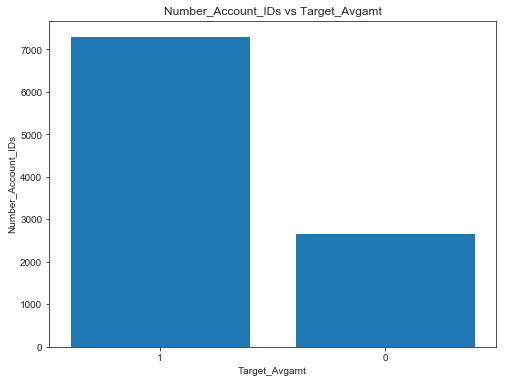

In [24]:
plt.figure(figsize=(8,6))
first = Counter(final_pivot_avgamt['target_avgamt'])
plt.bar(range(len(first)), first.values(), align='center')
plt.xticks(range(len(first)), list(first.keys()))
plt.xlabel('Target_Avgamt')
plt.ylabel('Number_Account_IDs')
plt.title('Number_Account_IDs vs Target_Avgamt')
plt.show()

#### The below graph model, shows a representation of 1 and 0 that indicate to customers who will 'Not Churn' and 'Churn' from the final_pivot_count table.

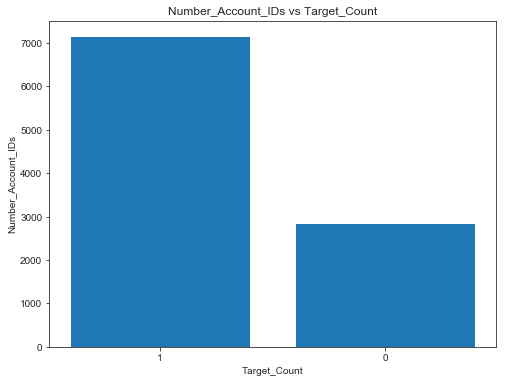

In [25]:
plt.figure(figsize=(8,6))
second = Counter(final_pivot_count['target_count'])
plt.bar(range(len(first)), second.values(), align='center')
plt.xticks(range(len(second)), list(second.keys()))
plt.xlabel('Target_Count')
plt.ylabel('Number_Account_IDs')
plt.title('Number_Account_IDs vs Target_Count')
plt.show()

#### Consider both table for final_pivot_count and final_pivot_avgamt.
#### We have calculated the Target values for each of these methods, may it be for amount or count.
#### It is essential to know which algorithm will give better sustainability, predictions and calculations. 
#### For this concern, we consider the target values of both of the pivot tables final_pivot_count and final_pivot_avgamount.
#### To find in the differences of these two data tables, we use AND operations between Target_Count and Target_Amount.
#### We then proceed to know the count of 1's (Depicting 'No churn' Customers) and 0's (Depicting 'Churn' Customers).

#### Observation: Post running the code, we have 410 changes from 'No Churn' and 'Churn' out of 9999 customers on the whole.

In [26]:
final_pivot_count['target'] = final_pivot_avgamt['target_avgamt'] & final_pivot_count['target_count']
final_pivot_avgamt['target'] = final_pivot_avgamt['target_avgamt'] & final_pivot_count['target_count']
final_data = pd.DataFrame()
final_data['target_count'] = final_pivot_count['target_count']
final_data['target_avgamt'] = final_pivot_avgamt['target_avgamt']
final_data['final_target'] = np.where(final_data['target_count'] == final_data['target_avgamt'], 1, 0)
Counter(final_data['final_target'])

Counter({1: 9589, 0: 410})

### MODEL BUILDING

#### A system is designed with 70% of Training Data and 30% Testing Data.
#### Random Forest Classifier is used to build the model
#### Reasons for Selecting Randon Forest Classifier:
#### 1. The problem is classification.
#### 2. The Dataset provided is non-linear.
#### 3. Random forest takes care of the over-fitting concerns.


#### A Model is trained on final_pivot_count dataframe along with the Assumed Target variables. This is further tested on data, which does not comprise of the target variables. 
#### This results in prediction values being analysed and that accounts for risk of 'Churn'.

In [27]:
X1_train, X1_test, y1_train, y1_test = train_test_split(final_pivot_count.drop(['before_count','after_count','percentage_count','target_count','target'], axis=1), final_pivot_count['target'], stratify = final_pivot_count.target, test_size = 0.7)

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X1_test)
clf.fit(X1_train,y1_train)

y1_pred=clf.predict(X1_test)

#### Below are the matrix associated with performance of the model on final_pivot_count dataframe which are confusion matrix, accuracy score and classification report. 
#### Classification Report provides precision, recall and F1 Score.

#### In the confusion matrix analysis:
#### 1. We have predicted 1984 0's(Churn) that were actually True.
#### 2. We have predicted 70 0's(Churn) that were actually False.
#### 3. We have predicted 4851 1's(No Churn) that were actually True.
#### 4. We have predicted 95 1's(No Churn) that were actually False.

0.9738571428571429
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2079
           1       0.98      0.98      0.98      4921

   micro avg       0.97      0.97      0.97      7000
   macro avg       0.97      0.97      0.97      7000
weighted avg       0.97      0.97      0.97      7000



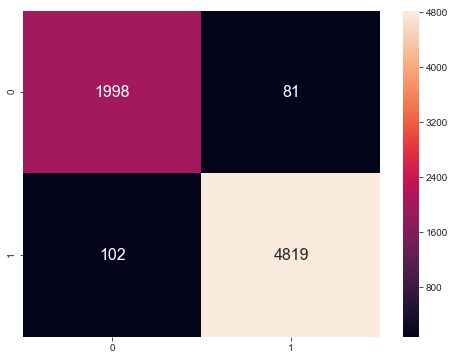

In [28]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y1_test, y1_pred), annot=True, fmt='g', annot_kws={'size':16})
print(accuracy_score(y1_test, y1_pred))
print(classification_report(y1_test, y1_pred))

#### A Model is trained on final_pivot_avgamt dataframe along with the Assumed Target variables. This is further tested on data, which does not comprise of the target variables. 
#### This results in prediction values being analysed and that accounts for risk of 'Churn'.

In [29]:
X2_train, X2_test, y2_train, y2_test = train_test_split(final_pivot_avgamt.drop(['before_avgamt','after_avgamt','percentage_avgamt','target_avgamt','target'], axis=1), final_pivot_avgamt['target'], stratify = final_pivot_avgamt.target, test_size = 0.7)

#Create a Gaussian Classifier
clf1=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X2_test)
clf1.fit(X2_train,y2_train)

y2_pred=clf1.predict(X2_test)

#### Below are the matrix associated with performance of the model on final_pivot_avgamt dataframe which are confusion matrix, accuracy score and classification report. 
#### Classification Report provides precision, recall and F1 Score.

#### In the confusion matrix analysis:
#### 1. We have predicted 1977 0's(Churn) that were actually True.
#### 2. We have predicted 77 0's(Churn) that were actually False.
#### 3. We have predicted 4844 1's(No Churn) that were actually True.
#### 4. We have predicted 102 1's(No Churn) that were actually False.

0.9767142857142858
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2079
           1       0.98      0.99      0.98      4921

   micro avg       0.98      0.98      0.98      7000
   macro avg       0.98      0.97      0.97      7000
weighted avg       0.98      0.98      0.98      7000



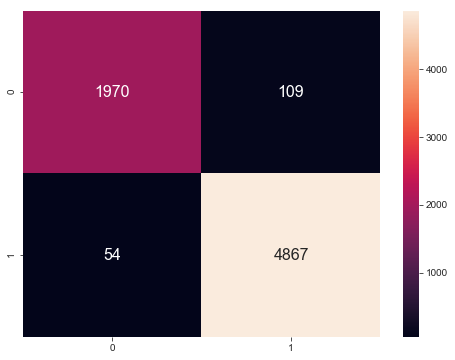

In [30]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y2_test, y2_pred), annot=True, fmt='g', annot_kws={'size':16})
print(accuracy_score(y2_test, y2_pred))
print(classification_report(y2_test, y2_pred))

### CONCLUSION

#### As per my observation from the performance metrics for both models(final_pivot_count and final_pivot_avgamt), both have identical behaviour.
#### We have built a model based on Count and Average Amount, which predicts the  Customer Churning concerns to the enterprise by accuracy score of ~97%.
#### We built target variables converting the unsupervised problem to a supervised problem. Further to which, we have built a classfication model, that is RANDOM FOREST CLASSIFIER. 
#### As a part of this assignment, we have covered areas of Feature Engineering, Building Model, and Performance Validation.